# Machine Learning Course @ IIUWr, Winter Semester 2019/2020
## End-of-semester project
### Authors: Kamil Listopad, Piotr Gdowski

### Goal:
The goal of this project was to better understand the Support Vector Machine and test it out on more real-life datasets.We have divided our project into three main parts:
- First of all, we have focused on our own SVM implementations and multiclass support.
- Then we compared the SVM accuracy and training/prediction time to the Multinomial Naive Bayes classifier on Reuters dataset used for document classification problem.
- Finally, we tried another classification problem on a dataset much different than Reuters.

### **Before You Read**

This notebook was designed to hide most of the code sections to provide the best reading experience.
If this is not the case and sections are not properly hidden, please follow the link to view it in colab:<br>
https://colab.research.google.com/drive/1XbWw27Sj3X_mrfwVELe0STYWqXhJIk2a

<!-- ### Plan of the project:

Our goal is to implement [Support Vector Machine Algorithm](https://en.wikipedia.org/wiki/Support-vector_machine) presented during the lecture in both versions with hard and soft margins.
It is said that SVM provides an impressive generalization performance on classification problems [citation](https://papers.nips.cc/paper/1949-a-parallel-mixture-of-svms-for-very-large-scale-problems.pdf).
We are going to verify this statement by comparing SVM to other popular classifiers like Naive-Bayes, Random Forest, KNN or Ada-Boost.

In our comparison, we will focus on:
- how the classifiers perform with various sizes of training data sets
- the performance on highly dimensional data (e.g. text categorization problem with sparse document vectors)
- time needed to train a model and classify a new sample

To unveil the full potential of the SVM method we want to experiment with several kernels (polynomial, gaussian) to show differences between them on particular datasets.
The basic SVM method solves the binary classification problem.
We will present how one can use the SVM to solve a multiclass problem.

The datasets of our choice will consist of standard toy datasets as well as several real-life/benchmark datasets, e.g. [Reuters](https://martin-thoma.com/nlp-reuters/) - a benchmark dataset for document classification.
- Document classification [Reuters dataset](https://martin-thoma.com/nlp-reuters/) tested [here](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf)
- [Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction/overview) tested in this [paper](https://papers.nips.cc/paper/1949-a-parallel-mixture-of-svms-for-very-large-scale-problems.pdf)
- [Forest Type Mapping DS](http://archive.ics.uci.edu/ml/datasets/Forest+type+mapping) -->

<!-- Possibly, we may want to extend SVM classifier into multiclass (>2) prediction. -->
<!-- Depending on time and will, we'll present some [extensions](https://en.wikipedia.org/wiki/Support-vector_machine#Extensions) with examples. -->
<!-- Finally, we'll compare selected SVM models with other popular classifiers like Naive-Bayes, Random Forest, KNN or Ada-Boost. -->


# Kernelized SVM Implementation with regularization (C)

### **Goal of this section**:

**We have provided a kernelized Soft-Margin SVM implementation both using a generic Quadratic Programming solver and the SMO algorithm.**

**For our SVM implementation to work on multiclass classification problems we have implemented both one-vs-one and one-vs-rest methods and tested which one performs better.**

### SVM problem formulation:

The main idea of Support Vector Machine algorithm is following: having points $x_1, ..., x_n$ and classes they belong to $y_1, ..., y_n$, where $y_i \in \{+1, -1\}$, we are looking for a hyperplane, which splits space into two, each containing points only from one class. Formally, we want to find a vector $\vec{w}$, normal to the hyperplane, such that 
* $\vec{w} \cdot x_i - b  \geq 1$ if $ y_i = 1$
* $\vec{w} \cdot x_i - b  \leq -1$ if $ y_i = -1$.

Or in other words

$\begin{equation}
 \large{ \forall{i} \enspace y_i (\vec{w} \cdot x_i - b) \geq 1}
 \end{equation}$.

So basically, we want to minimize $||\vec{w}||^2$ subject to $\forall{i} \enspace y_i (\vec{w} \cdot x_i - b) \geq 1$ for $i = 1, ..., n$


Please note, that having this definition we can't handle cases, when it's impossible to find such a perfectly splitting hyperplane. We want to tolerate outliers or mislabeled points. That's an inspiration to use a loss function, given by a formula: $ max(0, 1 - y_i (\vec{w} \cdot x_i - b)) $. If $x_i$ lies on the correct side of the margin, function's value is zero, otherwise proportional to the distance from the margin. 

Then, we want to minimize:

$\large{(\frac{1}{n} \sum_i max(0, 1 - y_i (\vec{w} \cdot x_i - b))) + \lambda ||\vec{w}||^2 }$, where $\lambda$ is a tradeoff size of margin and tolerance to errors. This approach is called **soft margin** SVM.

We can now equivantelly reformulate problem from above into the following quadratic programming problem:

$min_{w,b} \enspace \dfrac{1}{2}||w||^2 + C \sum_i  \xi_i$ 

s.t. $\forall{i} \enspace y_i (\vec{w} \cdot x_i - b) \geq 1 - \xi_i$

and $\forall{i} \enspace \xi_i \geq 0 $, where $\xi_i = max(0, 1 - y_i (\vec{w} \cdot x_i - b))$ and $C$ plays the same role as $\lambda$ in previous definition.

For quadratic programming problems there exists many ready to use solvers, like cvxopt.

Having $w, b$ we are able to classify new, not seen previously samples. Given a new point $x$, it is enough to calculate $ w^T \cdot x + b  = (\sum_i \alpha_i y_i x_i)^ T + b = \sum_i \alpha_i y_i \langle x_i, x \rangle + b$ and compare with 0. If greater, then $ y_x = 1 $, otherwise $ y_x = -1 $.

## SVM Implementation

### Imports

In [0]:
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt

import seaborn as sns

import sklearn.datasets
import sklearn.ensemble
import sklearn.svm
import sklearn.tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import GridSearchCV

import graphviz
import cvxopt

import time

sns.set()
sns.set_style('darkgrid')


# utils

def score_model(model, X, y):
    return (model.predict(X) == y).mean()

class Dict(dict):
    """"dict with dot access"""
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    __getattr__ = dict.get

d = Dict(one=1)
d.two = 2.
d

{'one': 1, 'two': 2.0}

### Kernels

In [0]:
def rbf(gamma):
    def _rbf(Xi, Xj):
        return np.exp(-gamma * np.linalg.norm(Xi - Xj) ** 2)
    return _rbf

def linear_kernel(a,b):
    return np.dot(a, b)

### SVM with QP solver

In [0]:
def predictor(model, x):
    def predict_one(x):
        w_phi_x = sum(model.alphas[i] * model.y[i] * model.kernel(model.X[i], x)
                    for i in model.support_)
        return w_phi_x + model.b

    xs = [x] if len(x.shape) == 1 else x
    return np.array([predict_one(x) for x in xs])


class SVM_QP:
    def __init__(self, C, kernel):
        self.C = float(C)
        self.kernel = kernel
        self.epsilon = 1e-5

    def fit(self, X, y):
        """
        y : m
        X : m x n
        """
        # Init
        self.X = X
        self.y = y.astype(np.float64)
        self.m_samples, self.n_features = X.shape
        y = X = None

        # Check shapes
        assert self.X.shape[0] == self.y.shape[0]
        # y classes should be 0 or 1
        for i in range(self.m_samples):
            assert self.y[i] == 0 or self.y[i] == 1
        # changes classes to -1 and 1
        self.y = 2 * self.y - 1

        # Calculate K matrix
        self.K = np.zeros((self.m_samples, self.m_samples))
        for i in range(self.m_samples):
            for j in range(self.m_samples):
                self.K[i,j] = self.kernel(self.X[i], self.X[j])

        # Solve using QP solver
        b = 0.0
        A = self.y.reshape((1,-1))
        q = np.ones(self.m_samples) * -1
        G = np.vstack((np.identity(self.m_samples) * -1,
                       np.identity(self.m_samples)))
        h = np.hstack((np.zeros(self.m_samples),
                       self.C * np.ones(self.m_samples))) # 2m x 1
        P = np.outer(self.y,self.y) * self.K

        cvxopt.solvers.options['show_progress'] = False
        res = cvxopt.solvers.qp(*map(cvxopt.matrix, [P, q, G, h, A, b]))
        del cvxopt.solvers.options['show_progress']

        # All alphas
        self.alphas = np.ravel(res['x']) # m x 1

        # Indexes of non-zero alphas - indexes of support vectors
        self.support_ = np.arange(self.m_samples)[self.alphas > self.epsilon]
        self.support_vectors_ = self.X[self.support_]
        self.dual_coef_ = [self.alphas[self.support_]]

        # Intercept
        b = sum(self.y[i] - sum(self.alphas[j] * self.y[j] * self.K[i,j]
                           for j in self.support_)
                for i in self.support_)
        b /= len(self.support_)
        self.b = b
        self.intercept_ = b

        return self

    def predict(self, x):
        return (predictor(self, x) > 0).astype(np.float64)


## SMO - Sequential minimal optimization

Let's go back to quadratic programming problem introduced in SVM algorithm, which focuses on calculating proper values of alphas under several conditions. The SMO algorithm presents another, iterative approach for this problem: on each step find $\alpha_i$ violating above conditions, then take some $\alpha_j$ and optimize both of them. The algorithm eventually converges. Implementation follows [this paper](http://cs229.stanford.edu/materials/smo.pdf).


In [0]:
class SMO:
    def __init__(self, kernel, C, tol=1e-3, max_passes=2):
        self.C = float(C)
        self.kernel = kernel
        self.tol = tol
        self.max_passes = max_passes
        self.epsilon = 1e-5

    def fit(self, X, y):
        self.m_samples, self.n_features = X.shape
        self.X = X
        self.y = y.astype(np.float64)
        assert self.X.shape[0] == self.y.shape[0]
        
        for i in range(self.m_samples):
            assert self.y[i] == 0 or self.y[i] == 1
        # changes classes to -1 and 1
        self.y = 2 * self.y - 1
        
        self.K = np.zeros((self.m_samples, self.m_samples))
        for i in range(self.m_samples):
            for j in range(self.m_samples):
                self.K[i,j] = self.kernel(self.X[i], self.X[j])

        def f(index): # f(x) = w^T * x + b
            return np.sum(self.alphas * self.y * self.K[index, :]) + self.b


        self.alphas = np.zeros(shape=self.m_samples)
        self.b = 0
        passes = 0
        while(passes < self.max_passes):
            num_changed_alphas = 0
            for i in range(self.m_samples):
                E_i = f(i) - self.y[i]
                if (self.y[i] * E_i < -self.tol and self.alphas[i] < self.C) or (self.y[i] * E_i > self.tol and self.alphas[i] > 0):
                    j = np.random.choice(list(range(0, i)) + list(range(i+1, self.m_samples)))
                    assert i != j
                    E_j = f(j) - self.y[j]
                    old_alpha_i, old_alpha_j = self.alphas[i], self.alphas[j]
                    L = max(0, self.alphas[j] - self.alphas[i]) if self.y[i] != self.y[j] else max(0, self.alphas[i] + self.alphas[j] - self.C)
                    H = min(self.C, self.C + self.alphas[j] - self.alphas[i]) if self.y[i] != self.y[j] else min(self.C, self.alphas[i] + self.alphas[j])
                    if L == H:
                        continue
                    ni = 2 * self.K[i,j] - self.K[i,i] - self.K[j,j]
                    if ni >= 0:
                        continue

                    alpha_j = self.alphas[j] - self.y[j] * (E_i - E_j) / ni
                    if alpha_j > H:
                        alpha_j = H
                    elif alpha_j < L:
                        alpha_j = L
                    
                    if abs(old_alpha_j - alpha_j) < self.tol:
                        continue

                    alpha_i = self.alphas[i] + self.y[i] * self.y[j] * (old_alpha_j - alpha_j)
                    
                    b_1 = self.b - E_i - self.y[i] * (alpha_i - old_alpha_i) * self.K[i,i] - self.y[j] * (alpha_j - old_alpha_j) * self.K[i,j]
                    b_2 = self.b - E_j - self.y[i] * (alpha_i - old_alpha_i) * self.K[i,j] - self.y[j] * (alpha_j - old_alpha_j) * self.K[j,j]
                        
                    if 0 < alpha_i < self.C:
                        b = b_1
                    elif 0 < alpha_j < self.C:
                        b = b_2
                    else:
                        b = (b_1 + b_2) / 2

                    num_changed_alphas += 1

                    self.alphas[i] = alpha_i
                    self.alphas[j] = alpha_j
                    self.b = b

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

        self.support_ = np.arange(self.m_samples)[self.alphas > self.epsilon]
        self.support_vectors_ = self.X[self.support_]
        self.dual_coef_ = [self.alphas[self.support_]]

        b = sum(self.y[i] - sum(self.alphas[j] * self.y[j] * self.K[i,j]
                           for j in self.support_)
                for i in self.support_)
        b /= len(self.support_)

        self.b = b
        self.intercept_ = b


    def predict(self, X):
        return (predictor(self, X) > 0).astype(np.float64)

## Multiclass Support

Some classifiers, like the SVM, are by their nature binary classifiers.
Yet we would like to use them to solve problems with more than two classes.
We implemented two standard approaches that allow solving multiclass classification problems using only binary classifiers: one-vs-one and one-vs-rest.

### One versus rest approach

In the one-vs-rest approach we are building $K$ classifiers, where $K = \#classes$, and each of them is trained on the whole training set, but with altered labels as follows: 

For $i$-th classifier if a sample comes from the $i$-th class then it has label $1$, otherwise it's labeled with $0$.

To predict a new sample we use the trained binary classifers to predict the **score** (not a class) and then we assign the new sample's label to $i$ if the $i$-th classifier has the highest score.

### Score function:

It's somewhat uncertain how to provide the score if usually classifiers just pick labels for given samples (unlike in regression where we get the predicted value).

In the context of kernelized SVM we calculate the score as follows:
$w^T\phi(x) + b$.
If this value is positive then in the binary case we would classify a sample as $1$, so naturally if we have many classifiers then we pick the one with the most positive (most confident) value.

### **Remarks:**
- Even if the dataset is balanced, since we train each classifier on the whole dataset with changed labels to $0$ almost everywhere, each classifier learns on an unbalanced dataset.
- Due to the fact that each classifier trains on the whole dataset, this greatly increases the training/prediction time compared to the next method: one-vs-one

In [0]:
def transform_data_1_vs_rest(y, target):
    y = y.copy()
    # print(target, y)
    ids_1 = y == target
    ids_0 = y != target
    assert ids_1.sum() + ids_0.sum() == len(y)
    y[ids_1] = 1.
    y[ids_0] = 0.
    # print(y,'\n')
    return y


class Multi_1vR:
    def __init__(self, mk_model):
        self.mk_model = mk_model

    def fit(self, X, y):
        y = y.ravel()
        self.X = X
        self.y = y
        self.targets = np.unique(y)

        self.models = {}
        for t in tqdm_notebook(self.targets, desc='1vRest clf'):
            model = self.mk_model()
            self.models[t] = model
            model.fit(X, transform_data_1_vs_rest(y, t))

        return self

    def predict(self, x):
        def score_target(t):
            model = self.models[t]
            vals  = predictor(model, x)
            return vals

        scores = np.array([score_target(t) for t in self.targets])
        ids = scores.argmax(axis=0)
        best_model_ids = self.targets[ids]
        return np.array(best_model_ids)


def filter_data_1_vs_1(X, y, target_pair):
    """returns X, y only from targets ti or tj, with changed targets to 0 and 1"""
    ti, tj = target_pair
    # print(target_pair)
    # print(y)
    assert ti > tj
    ids = np.array([c in target_pair for c in y])
    X = X[ids]
    y = y[ids]
    zeros = y == ti
    ones  = y == tj
    y[zeros] = 0.
    y[ones ] = 1.
    # y = (y - ti) / (tj - ti)
    # print(y)
    return X, y

### One versus one approach

In the one-vs-one approach we are building $K(K-1)/2$ binary classifiers, one for each pair of classes, where $K = \#classes$.

The binary classifiers are trained only on the samples with labels that come from the classifier's pair of classes, meaning that each classifier learns to distinguish these two classes from his pair.

Prediction is much simpler compared to the one-vs-rest for all we have to do is to predict a new sample using every classifier and the final prediction is picked using the majority vote.

### **Remarks:**
- Even though we have much more classifiers than in the one-vs-rest approach, training time with one-vs-one is much shorter, while we did not observe much difference in the accuracy between those two approaches.


In [0]:
class Multi_1v1:
    def __init__(self, mk_model):
        self.mk_model = mk_model 

    def fit(self, X, y):
        y = y.ravel()
        self.X = X
        self.y = y
        self.targets = np.unique(y)

        self.target_pairs = [(ti, self.targets[j]) for i, ti in enumerate(self.targets) for j in range(i)]

        self.models = {}
        for t in tqdm_notebook(self.target_pairs, desc='1v1 clf'):
            model = self.mk_model()
            self.models[t] = model
            model.fit(*filter_data_1_vs_1(self.X, self.y, t))

        return self

    def predict(self, x):
        def predict_target_pair(t):
            preds = self.models[t].predict(x)
            zeros = preds == 0.
            ones  = preds == 1.
            assert zeros.sum() + ones.sum() == len(x)
            preds[zeros] = t[0]
            preds[ones ] = t[1]
            return preds

        preds = np.array([predict_target_pair(t) for t in self.target_pairs])
        ids = sstats.mode(preds, axis=0).mode
        return ids

## Iris dataset as simple testset

We used Iris dataset to visualize decision boundaries of our SVM classifiers with different multiclass approaches.

**First**, we visualize the iris dataset with colors that indicate classes.<br>
**Then** we plot decision boundaries for both multiclass methods as follows:
- plots in the first row show the decision boundaries of each classifier used in the method
- the second row presents the final decision boundary after combining the sub-classifiers

#### Plotting utils

In [0]:
#title 2D plot utils
def plot_dataset(x, y, c):
    scatter = plt.scatter(x, y, c=c, cmap='spring', edgecolors='k')
    plt.legend(*scatter.legend_elements(), loc="upper left", title="Class")
    plt.xlabel('petal_length')
    plt.ylabel('petal_width')

def plot_decision_boundary(X, y, model):
    # assert len(X.shape) == 2
    # X = X.T if X.shape[0] != 2 else X
    y = y.ravel()
    dataXs = X[:, 0]
    dataYs = X[:, 1]

    xs, ys = np.meshgrid(
        np.linspace(dataXs.min(), dataXs.max(), 100),
        np.linspace(dataYs.min(), dataYs.max(), 100))

    grid = np.vstack([xs.ravel(), ys.ravel()])

    predictions_Grid = model.predict(grid.T)
    plt.contourf(xs, ys, predictions_Grid.reshape(xs.shape), cmap='spring')
    # c = ['r' if x == 0 else ('g' if x == 1 else 'b') for x in Y.ravel()]
    # plt.scatter(dataXs, dataYs, c=y, cmap='spring', edgecolors='k')
    plot_dataset(dataXs, dataYs, y)

def plot_binary_models(X, y, model):
    n = len(model.models.keys()) # number of plots
    plt.figure(figsize=(6*n,4))
    for i, (t, binary_model) in enumerate(model.models.items()):
        plt.subplot(1, n, i+1)
        plot_decision_boundary(X, y.ravel(), binary_model)
        plt.title(f"Model for target {t}")
    plt.show()

def plot_multi_model(X, y, m):
    m.fit(X, y)

    plot_binary_models(X, y, m)
    plt.figure()
    plot_decision_boundary(X, y, m)
    plt.show()

In [0]:
# load iris
iris = sklearn.datasets.load_iris()
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]
IrisX2F = np.vstack([petal_length, petal_width])
IrisY = (iris.target).reshape(1,-1).astype(np.float64)

iris_n_features, iris_m_samples = IrisX2F.shape
iris_gamma = 1 / iris_n_features

def iris_plot():
    plot_dataset(IrisX2F[0], IrisX2F[1], c=IrisY.ravel())
    # scatter = plt.scatter(IrisX2F[0], IrisX2F[1], c=IrisY.ravel(), cmap='spring', edgecolors='k')
    # plt.legend(*scatter.legend_elements(), loc="upper left", title="Class")

def iris_plot_multi_model(m):
    plot_multi_model(IrisX2F.T, IrisY.ravel(), m)

### Iris - test SVM_QP - one vs rest (with RBF kernel)

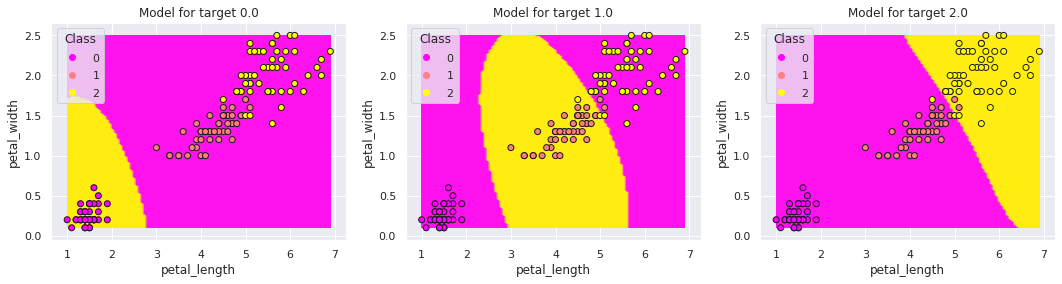

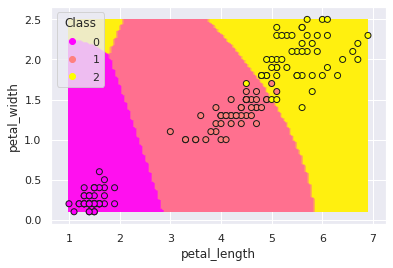

In [0]:
iris_plot_multi_model(Multi_1vR(lambda: SVM_QP(kernel=rbf(iris_gamma), C=1)))

### Iris - test SMO - one vs one (with RBF kernel)


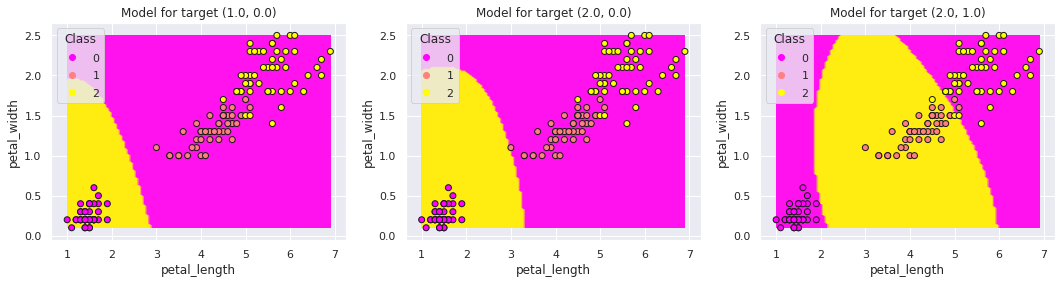

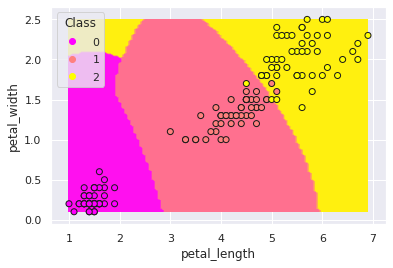

In [0]:
iris_plot_multi_model(Multi_1v1(lambda: SMO(kernel=rbf(iris_gamma), C=2)))

## Plot Iris dataset

The plot below shows the iris dataset used in the following examples.

The classes/targets are numerical values: $0, 1, 2$

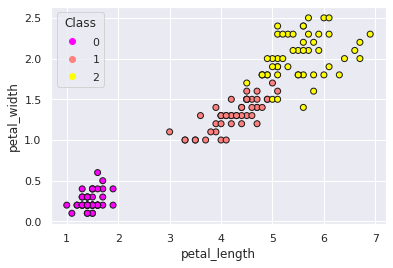

In [0]:
iris_plot()

## Iris - test SVM_QP - **one vs one** (with linear kernel)

In the first example we use **SVM** implementation with **QP solver**. The kernel is **linear** and multiclass method is **one-vs-one**.

Please note that even though we plot every sample from the dataset, the sub-classifiers only see those samples with classes relevant to the sub-classifier.<br>
For example in the plot titled `Model for target (2.0, 0.0)` the classifier ignored samples with label $1$.

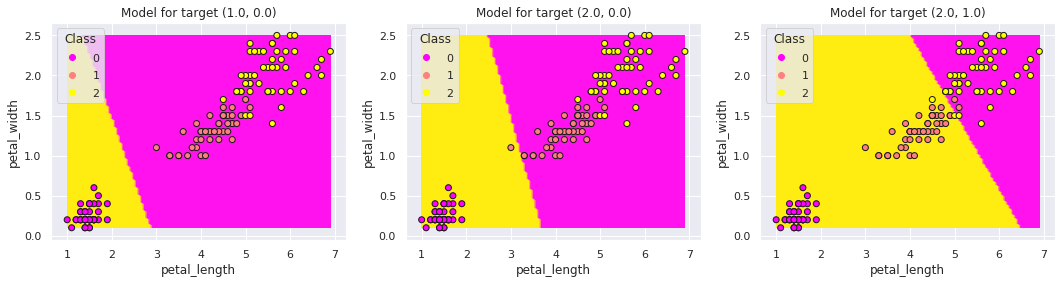

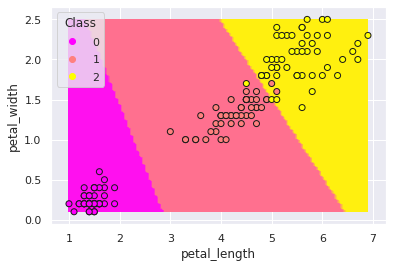

In [0]:
iris_plot_multi_model(Multi_1v1(lambda: SVM_QP(kernel=linear_kernel, C=1)))

## Iris - test SMO - **one vs rest** (with linear kernel)

The second example uses **SVM** implementation with **SMO** algorithm. The kernel is also **linear** but multiclass method is **one-vs-rest**.

In this case sub-classifiers see every sample, but only one class is relevant for each classifier so they only learn to distinguish this one class from others.<br>
For example consider the plot below titled `Model for target 1.0`.
The class $1$ is relevant for this sub-classifier, so in this case points are not linearly separable (even with soft margin) that's why the decision boundary looks somewhat random.

Yet the final result is good enough.


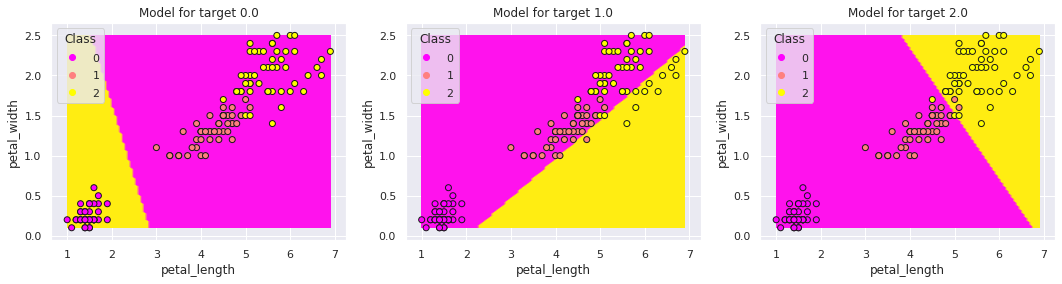

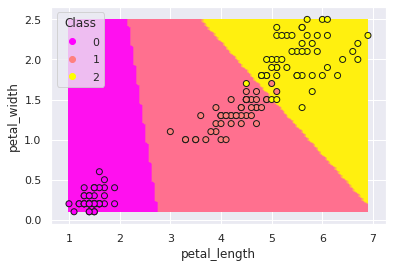

In [0]:
iris_plot_multi_model(Multi_1vR(lambda: SMO(kernel=linear_kernel, C=10)))

# Dataset: [Reuters](https://martin-thoma.com/nlp-reuters/)

### **Motivation**:

During the Kaggle competition with tweets database, we weren't able to make SVM perform better than Multinomial Naive Bayes classifier.

That was a discouraging experience that even though we learnt during lectures that SVM not only performs well in practice but also has nice theoretical properties and then seeing it much slower than MNB on vectorized tweets with worse accuracy.

After some research, we found the claim that SVM performs better at full-length documents whereas MNB provides more significant results on snippets [\[citation\]](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf).
Since tweets are relatively short texts that might be the case why SVM underperformed on that dataset.

To test this claim we used the Reuters dataset for document classification problem to see wheter its enormous feature space (~26k dimensions) actually makes SVM better in this case.

## Download and load dataset

In [0]:
import nltk
nltk.download('reuters')
nltk.download('stopwords')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
n_classes = 90
labels = reuters.categories()

# Code taken from: https://martin-thoma.com/nlp-reuters/#data-loading
def load_data(config={}):
    stop_words = stopwords.words("english")
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    mlb = MultiLabelBinarizer()

    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    xs = {'train': [], 'test': []}
    xs['train'] = vectorizer.fit_transform(docs['train']).toarray()
    xs['test'] = vectorizer.transform(docs['test']).toarray()
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': xs['train'], 'y_train': ys['train'],
            'x_test': xs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data

In [0]:
config = {}
data = load_data(config)

In [0]:
full_dataset = Dict()
full_dataset.x_train = data['x_train']
full_dataset.y_train = np.argmax(data['y_train'], axis = 1).astype(np.float64)
full_dataset.x_test = data['x_test']
full_dataset.y_test = np.argmax(data['y_test'], axis = 1).astype(np.float64)

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def show_tsne(dataset):
    pre_decomp = PCA(n_components=100)
    x_train_cut = pre_decomp.fit_transform(dataset.x_train) # to speed up and avoid noises on T-SNE computations 
    decomp = TSNE(n_components=2)
    x_train_cut = decomp.fit_transform(x_train_cut)
    plt.figure(figsize=(20,10))
    plt.title('Full dataset, embed into space computed with T-SNE algorithm')
    plt.scatter(x = x_train_cut[:, 0], y = x_train_cut[:, 1] , c=dataset.y_train.ravel(), alpha = 0.5, marker='.')
    plt.show()

## Dataset visualisation

Let's have a look if there are some obvious dependencies between classes. To achieve this, we embed and plot full dataset in two dimensional space using T-SNE algorithm.

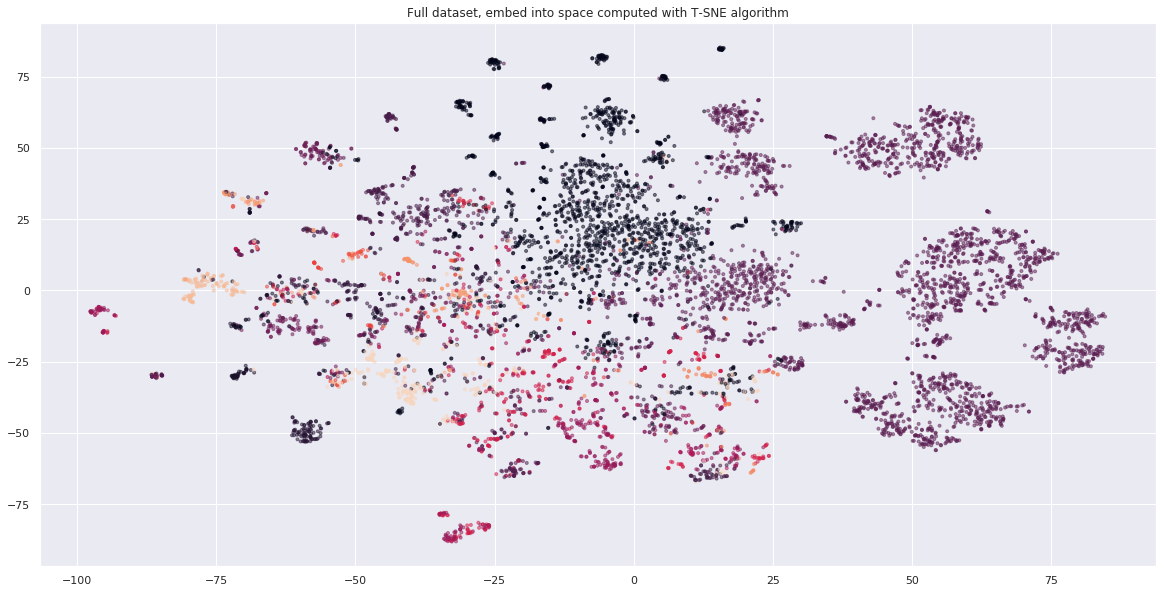

In [0]:
show_tsne(full_dataset)

The plot above shows many clusters of consistent color, which are easily separable with a line, so SVM with linear kernel can perform well on this dataset.


## Classification on full dataset

In this section we'll try to find out best parameters for two selected classifiers: LinearSVC and MultinomialNaiveBayes.

#### Linear Soft-Margin SVM (libsvm)

Firstly, we will test SVM classifier with a linear kernel. Starting with default parameters we get high accuracy above 80%.

Next we attempt hyperparameter tuning using 5-fold cross validation to find the best C. 

In [0]:
from sklearn.svm import LinearSVC
m_sgd = LinearSVC()
%time m_sgd.fit(full_dataset.x_train, full_dataset.y_train)
%time score_model(m_sgd, full_dataset.x_test, full_dataset.y_test)

CPU times: user 3.68 s, sys: 1.98 ms, total: 3.69 s
Wall time: 3.69 s
CPU times: user 1.23 s, sys: 158 ms, total: 1.39 s
Wall time: 492 ms


0.8983106989069228


Best score 0.8962527793178147 for C=1.7894736842105263
Final accuracy on the test set: 0.9012918184829414 

  accuracy on the whole    test set: 0.9012918184829414


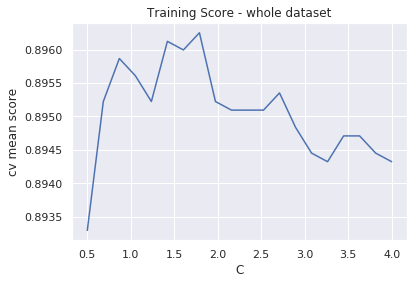

In [0]:
#@title Search for the best hyper parameter C
import warnings
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

cs = np.linspace(0.5, 4.0, num=20) #@param

def tune_svm(cs, dataset, *, suppress_warnings=False, color=None):
    if suppress_warnings:
        warnings.filterwarnings(action='ignore', category=UserWarning)

    scores = np.array(
        [cross_validate(LinearSVC(C=c, max_iter=5e3),
                        dataset.x_train, dataset.y_train)['test_score'].mean()
         for c in tqdm_notebook(cs, desc='Fitting Cs')])

    warnings.resetwarnings()
    # -- manual way
    # models = np.array([LinearSVC(C=c, max_iter=5e3).fit(x_train, y_train) for c in cs])
    # scores = np.array([score_model(m, x_test, y_test) for m in models])
    best_id = scores.argmax()
    best_score = scores[best_id]
    best_C = cs[best_id]

    weak_ids = scores < 0.8
    ok_ids = (1 - weak_ids).astype(bool)

    if weak_ids.sum() > 0:
        print('Filter out low scores. #Skipped =', weak_ids.sum())

    plt.plot(cs[ok_ids], scores[ok_ids], c=color)
    plt.xlabel('C')
    plt.ylabel('cv mean score')

    print(f'Best score {best_score} for C={best_C}')

    # return models[best_id] 
    return LinearSVC(C=best_C, max_iter=5e3).fit(dataset.x_train, dataset.y_train)


# plt.figure(figsize=(6*2,4))
# plt.subplot(1, 2, 1)
best_svm = tune_svm(cs, full_dataset, suppress_warnings=True, color='b')
plt.title("Training Score - whole dataset")

# plt.subplot(1, 2, 2)
# best_svm_relevant = tune_svm(cs, x_train=x_train_relevant, y_train=y_train_relevant, color='r')
# plt.title("Training Score - relevant dataset")
# plt.show()

# plt.legend(['whole', 'relevant'])
print('Final accuracy on the test set:', score_model(best_svm, x_test, y_test), '\n')
# print('SVM trained on the relevant train samples')
print('  accuracy on the whole    test set:', score_model(best_svm, x_test, y_test))
# print('  accuracy on the relevant test set:', score_model(best_svm_relevant, x_test_relevant, y_test_relevant))

### **SVM Conclusions**

Hyperparameter tunning allowed us to reach close to 90% accuracy, which is an improvement over the default SVM model.

### Why SVM performs well for document classification problems

As pointed out in this [paper](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf) - following properties of text account for SVM good performance:
- **High dimensional input space**: SVMs with carefully chosen regularization parameter $C$ can mitigate the problem with many features preventing overfitting
- **Few irrelevant features**: According to the future section [Lowering dimensionality of dataset](#lowering-dimensionality-of-dataset) which presents results that most of the features in the Reuters dataset are independent hence any reduction of dimensions will probably negatively affect classifers' accuracy.


### Multinomial Naive Bayes

Naive Bayes turned out to be significantly better in terms of accuracy and training/prediction time in the kaggle competition on the tweets database compared to the SVM.

Obviously we wanted to compare those on the Reuters dataset, where the situation is similar - we are doing text classification. The difference is that now our dataset has significantly more dimensions.

The SVM shows its superiority in this case.
We used GridSearch to tune the alpha parameter of the Multinomial Naive Bayes for best performance.
Then we tested the tuned model on the test set.
The MNB accuracy is still considerably high, almost reaching the untuned SVM score, yet we couldn't do much better than that.

### **Conclusion**

This might suggest (as argued in [this paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)) that **SVM performs better with longer documents** whereas **Naive Bayes is better at snippets**.
It might be the case with tweets for they are relatively short documents. 

In [0]:
param_grid = [{'alpha': np.linspace(1e-10, 0.3, num=20)}]
gridM = GridSearchCV(MultinomialNB(), param_grid, )
%time gridM.fit(full_dataset.x_train, full_dataset.y_train)

print(gridM.best_score_)
print(gridM.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 6min 7s, sys: 1min 12s, total: 7min 19s
Wall time: 2min 35s
0.8154218886350245
{'alpha': 0.01578947377894737}


### MNB - Searching for optimal alpha parameter

The plot below suggests that in this case the Naive Bayes classifier performs best when Laplace smoothing is very minor for alphas close to zero, but non-zero.

0.823782709506459

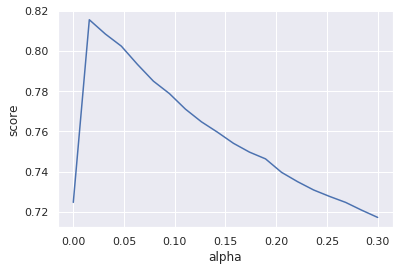

In [0]:
#@title Plot the GridSearch results not MultinomialNB classifer
alphas = gridM.cv_results_['param_alpha'].data
scores = gridM.cv_results_['mean_test_score']
plt.plot(alphas, scores)
plt.xlabel('alpha')
plt.ylabel('score')

score_model(gridM.best_estimator_, full_dataset.x_test, full_dataset.y_test)

## Dataset preprocessing

We decided to decrease size of dataset due to several problems we came across while doing research and running computations on our handwritten classifiers. The first serious reason is enormous number of classes which results in very long learning time of our 1v1 and 1vRest classifier. Because of that, we've removed underrepresented samples from training set and corresponding ones from test set. The following analysis helped us to figure out sensible threshold for class representation.

### Class distribution

Visualize number of samples from each class/target.<br>
First in the **train dataset** and then in the **test dataset**.

The outputs below show:
- Sorted number of samples from each class
- Top 5 classes with highest number of samples
- Class distribution plot

### **Conclusions:**
- Both datasets are heavily unbalanced
- However classes in both train and test datasets are similarly distributed.


In [0]:
def targets_distribution(y):
    return pd\
        .crosstab(index=y, columns='count', rownames=['target'])\
        .sort_values(by='count', ascending=False)\
        .reset_index()

In [0]:
def present_targets(y):
    plt.figure(figsize=(12,4))
    plt.title('Class/Target distribution')
    sns.distplot(y, hist=False)
    plt.xlabel('target/class')

    classes = targets_distribution(y)

    print('Sorted class counts:\n', classes['count'].values, '\n')
    print('Top count classes:\n',classes.iloc[:5],'\n')

    return classes

### Distribution of classes in training dataset:

Sorted class counts:
 [2843 1650  370  329  266  253  218  157  126  125  112  101   98   83
   82   75   67   55   49   49   45   39   39   37   37   35   32   31
   28   26   21   19   19   19   18   17   15   15   14   14   13   12
   11   10    9    8    8    6    6    6    5    4    4    4    4    3
    3    3    2    2    2    2    2    2    1    1    1    1    1    1
    1    1    1    1] 

Top count classes:
 col_0  target  count
0        21.0   2843
1         0.0   1650
2        17.0    370
3        34.0    329
4        46.0    266 



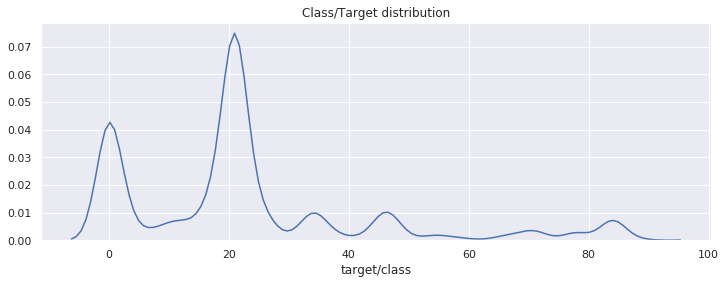

In [0]:
train_classes = present_targets(full_dataset.y_train)

### Distribution of classes in testing dataset:

Sorted class counts:
 [1083  719  182  124   96   77   76   48   43   39   30   29   26   25
   25   24   22   19   17   17   15   14   14   14   14   13   13   13
   12   11   11   10    9    9    9    9    9    6    6    6    6    6
    5    5    5    4    4    4    3    3    3    3    3    3    2    2
    2    2    2    2    1    1    1    1    1    1    1    1    1    1
    1    1] 

Top count classes:
 col_0  target  count
0        21.0   1083
1         0.0    719
2        17.0    182
3        34.0    124
4        46.0     96 



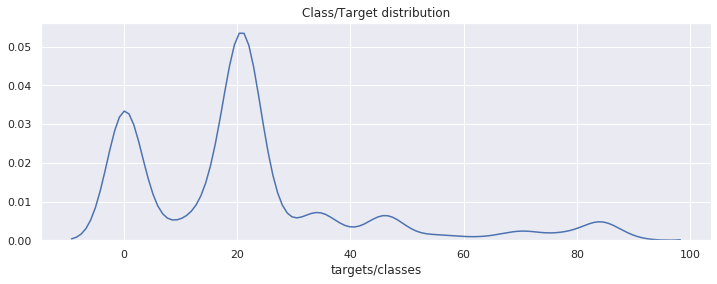

In [0]:
test_classes = present_targets(full_dataset.y_test)

### Generating relevant dataset
We are going to exclude classes with negligible count numbers and use the dataset result for training comparison with the whole dataset.

In [0]:
#@title Code
def get_relevant_dataset(source_dataset, negligible_class_count):
    negligible = negligible_class_count

    train_classes = targets_distribution(source_dataset.y_train)
    test_classes = targets_distribution(source_dataset.y_test)

    test_negligibles = test_classes[test_classes['count'] <= negligible].target.values
    train_negligibles = train_classes[train_classes['count'] <= negligible].target.values
    print(f'Relevant classes are those with more than {negligible} samples')

    print('\nNumber of not relevant classes in:')
    print('  Test  dataset  :',len(test_negligibles))
    print('  Train dataset  :',len(train_negligibles))
    print('  Common for both:',len(set(test_negligibles) & set(train_negligibles)))

    train_relevant = [t not in train_negligibles for t in source_dataset.y_train]
    relevant_ds = Dict()
    relevant_ds.x_train = source_dataset.x_train[train_relevant]
    relevant_ds.y_train = source_dataset.y_train[train_relevant]

    print("\nNumber of samples in train dataset:")
    print("  whole   :", source_dataset.y_train.shape[0])
    print("  relevant:", relevant_ds.y_train.shape[0])
    print('Number of dropped train samples: ', source_dataset.y_train.shape[0] - relevant_ds.y_train.shape[0])

    # Exclude test samples whose classes are not present in the train set
    test_relevant = [t not in train_negligibles for t in source_dataset.y_test]
    relevant_ds.x_test = source_dataset.x_test[test_relevant]
    relevant_ds.y_test = source_dataset.y_test[test_relevant]
    
    print("\nNumber of samples in test dataset:")
    print("  whole   :", source_dataset.y_test.shape[0])
    print("  relevant:", relevant_ds.y_test.shape[0])
    print('Number of dropped test samples: ', source_dataset.y_test.shape[0] - relevant_ds.y_test.shape[0])
    return relevant_ds

In [0]:
negligible_class_count = 40 #@param
relevant_ds = get_relevant_dataset(full_dataset, negligible_class_count)

Relevant classes are those with more than 40 samples

Number of not relevant classes in:
  Test  dataset  : 63
  Train dataset  : 53
  Common for both: 46

Number of samples in train dataset:
  whole   : 7769
  relevant: 7153
Number of dropped train samples:  616

Number of samples in test dataset:
  whole   : 3019
  relevant: 2738
Number of dropped test samples:  281


### **Remarks:**

The output above indicates which classes are considered irrelevant in the test set, train set and in both of them.

We picked classes with at least 40 samples in the train set because we will use 5-fold cross validation later. We are going compare whether we gain more accuracy on the whole test set if we train on the relevant train set.

### Lowering number of samples in datasets

Above considerations are not sufficient. 7k samples is still too much to finish training in reasonable time. We have to remove at least half of the samples then.

In [0]:
# Sample smaller dataset 

def sample_dataset(dataset, train_size, test_size):
    train_size = dataset.x_train.shape[0] if train_size < 0 else train_size
    test_size = dataset.x_test.shape[0] if test_size < 0 else test_size

    train_ids = np.arange(dataset.x_train.shape[0])
    train_ids = np.random.choice(train_ids, train_size, replace=False)

    test_ids = np.arange(dataset.x_test.shape[0])
    test_ids = np.random.choice(test_ids, test_size, replace=False)

    ds = Dict()

    ds.x_train = dataset.x_train[train_ids]
    ds.y_train = dataset.y_train[train_ids]

    ds.x_test = dataset.x_test[test_ids]
    ds.y_test = dataset.y_test[test_ids]

    # print(ds.x_train.shape, ds.y_train.shape, ds.x_test.shape, ds.y_test.shape)

    return ds

In [0]:
training_size =  2000#@param
test_size =  200#@param

reduced_ds = sample_dataset(relevant_ds, training_size, test_size)

### Lowering dimensionality of dataset

The another idea how to cope with huge learning time is to reduce number of columns in dataset. To achieve this, we used PCA algorithm.

In [0]:
#@title Code
def show_eigenvalues(x):
    vals, vecs = np.linalg.eigh(np.cov(x))
    order = np.argsort(vals)[::-1]
    vals = vals[order]
    vecs = vecs[order]

    plt.semilogy()
    plt.plot(range(len(vals)), vals)
    plt.title('Eigenvalues of the covariance martix of the training dataset')
    plt.show()
    return vals


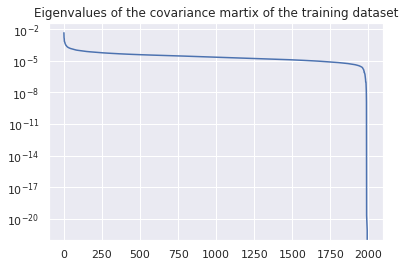

In [0]:
eigen_vals = show_eigenvalues(reduced_ds.x_train)

Low eigenvalues of dataset's covariance matrix imply low or none dependence of dimensions. However, a training/testing time will be definitely less time-consuming, so it's worth giving this approach a try. We just have to pick the target dimensionality.

In [0]:
target_dimensionality = sum(eigen_vals > 1e-4)
target_dimensionality

94

In [0]:
#@title Code
def get_pcaed_dataset(dataset, target_dimensionality):
    decomp = PCA(n_components=target_dimensionality)

    pcaed_ds = Dict()
    pcaed_ds.x_train = decomp.fit_transform(dataset.x_train)
    pcaed_ds.y_train = dataset.y_train
    pcaed_ds.x_test = decomp.transform(dataset.x_test)
    pcaed_ds.y_test = dataset.y_test

    return pcaed_ds


## Classification on reduced datasets with our SVM implementations 

In this section we compare the effiecency of our SVM implementations with sklearn's LinearSVC. We measure the training time, prediction time and naturally the accuracy. We prepared three datasets of 2000 samples and corresponding ones in smaller space, so the average results can be reliable. 



### Analysis

In [0]:
toy_ds = sample_dataset(relevant_ds, 100, 10)

In [0]:
reduced_ds1 = sample_dataset(relevant_ds, training_size, test_size)
reduced_ds2 = sample_dataset(relevant_ds, training_size, test_size)
reduced_ds3 = sample_dataset(relevant_ds, training_size, test_size)
pcaed_ds1 = get_pcaed_dataset(reduced_ds1, 100)
pcaed_ds2 = get_pcaed_dataset(reduced_ds2, 100)
pcaed_ds3 = get_pcaed_dataset(reduced_ds3, 100)

In [0]:
datasets = [
    reduced_ds1,
    reduced_ds2,
    reduced_ds3,
    pcaed_ds1,
    pcaed_ds2,
    pcaed_ds3,
]

ds_labels = ['Relevant dataset', 'PCAed dataset']

In [0]:
classifiers = [
    Multi_1v1(lambda: SVM_QP(kernel=linear_kernel, C=10)),
    Multi_1vR(lambda: SVM_QP(kernel=linear_kernel, C=10)),
    Multi_1v1(lambda: SMO(kernel=linear_kernel, C=10)),
    Multi_1vR(lambda: SMO(kernel=linear_kernel, C=10)),
    LinearSVC()
]

clf_labels = ['SVMQP 1v1', 'SVMQP 1vR', 'SMO 1v1', 'SMO 1vR', 'Libsvm']

In [0]:
def compose_dataframe(results): 
    results = np.array(returned_results)
    results = np.array(returned_results).reshape((5, 3,-1))
    data = (results.sum(axis=1) / 3)
    idx = pd.MultiIndex.from_product([ds_labels, ['score', 'train time', 'predict time']])
    df = pd.DataFrame(data, columns= idx, index = clf_labels)
    return df

In [0]:
import itertools
import time

def run_analysis():
    results = []
    for clf, ds in tqdm_notebook(list(itertools.product(classifiers, datasets)), desc='Main loop'):
        training_start = time.time()
        clf.fit(ds.x_train, ds.y_train)
        training_end = time.time()
        score = score_model(clf, ds.x_test, ds.y_test)
        scoring_end = time.time()
        results.append([score, training_end - training_start, scoring_end - training_end])

    return results

In [0]:
returned_results = run_analysis()

### Results

In [0]:
compose_dataframe(returned_results)

Relevant dataset               ... PCAed dataset             
                     score   train time  ...    train time predict time
SVMQP 1v1            0.890   306.708166  ...    187.277275    25.236417
SVMQP 1vR            0.910  1296.717349  ...    866.453860    10.803401
SMO 1v1              0.890   431.488547  ...    311.222258    26.676322
SMO 1vR              0.910  1770.660968  ...   1279.073867    11.266201
Libsvm               0.905     0.397632  ...      0.311476     0.005990

[5 rows x 6 columns]

**Conclusions:**

The **one-vs-one** method come out to be much faster, even though it uses quadratic $O(\#classes^2)$ number of models, but each trained on a small fraction of the train data set, while **one-vs-rest** uses one model for each class and trains every one of them on the whole set leading to the increased training time.

The SMO approach to solve quadratic programming problem didn't achieve much better accuracy, let alone better training and predicting times. 

Dataset transformation with PCA indeed improve time of training and testing, but obtained prediction scores are comparable.

All times and results are - surprisingly - worse than those obtained from sk-learn LinearSVM classifier.

# DataSet: *Forest Cover Type Prediction*

### **Motivation**

For a more diverse experience, we have picked up yet another dataset that is different than Reuters - with fewer dimensions and a mixture of categorical and numerical variables.
We came across the dataset used for Forest Cover Type classification.

### **Accomplishments**

It turns out that the forest dataset is best predicted using Random Forest Classifier.

We tried to train SVM to compete with that.
A huge amount of samples does not allow the use of SVC or other quadratic solution (including our own SVM implementation).
So we tried to use LinearSVM which is faster then former SVM variants.
Yet we still wanted to test out other kernels.

But since we couldn't use the kernelized version because of the performance issues we chose to find the approximated feature map for RBF (and poly) kernel and use it in conjunction with LinearSVM.
The idea is similar to fitting a polynomial in linear regression - we first map the features using approximated feature map and then we use LinearSVM for training/prediction.

Other challenge that we faced was that unlike Reuters this dataset needed to be normalized in order to classify it properly.

<!-- Info - where the dataset is mentioned:
- [Kaggle competition](https://www.kaggle.com/c/forest-cover-type-prediction/overview)
- [Related paper](https://papers.nips.cc/paper/1949-a-parallel-mixture-of-svms-for-very-large-scale-problems.pdf)
- [Whole dataset](http://archive.ics.uci.edu/ml/datasets/Covertype) not used here -->

<!-- Done:
- Non-categorical data normalization
- Simple testing several classifiers
- Working example with libsvm that uses approximated kernel map + LinearSVM instead of slow SVC (with quadratic training time) - I guess our implementation won't be faster so that's the problem
- Finding better parameters for used classifiers - how to search for those parameters in an automatic way -->

## Data Statistics

- Number of samples in the dataset is $15120$
- Number of features is $54$ ($10$ numerical and $44$ categorical features)
- Scales for numerical features are different - there's **need for normalization**
- Total of 7 different classes
- Balanced dataset - each class contains $2160$ samples

### Download the dataset from kaggle (can be rerun safely)

In [0]:
import json
! pip install -q kaggle
# from google.colab import files
# files.upload()
kaggle_api_key = {"username":"kamillistopad","key":"a5dda8e813d8a966e88251d77a4a7d61"}
with open("kaggle.json", mode='w') as f:
    json.dump(kaggle_api_key, f)
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c forest-cover-type-prediction
! unzip test.csv.zip
! unzip train.csv.zip
! mkdir forestdata
! mv test.csv forestdata/test.csv
! mv train.csv forestdata/train.csv
! rm test.csv.zip train.csv.zip
! echo "forestdata/"
! ls forestdata
del kaggle_api_key

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test3.csv: Skipping, found more recently modified local copy (use --force to force download)
 92% 11.0M/11.9M [00:00<00:00, 115MB/s]
100% 11.9M/11.9M [00:00<00:00, 111MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/351k [00:00<?, ?B/s]
100% 351k/351k [00:00<00:00, 49.3MB/s]
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
mkdir: cannot create directory ‘forestdata’: File exists
forestdata/
test.csv  train.csv


In [0]:
forest_test_df = pd.read_csv('forestdata/test.csv')

print(forest_test_df.shape)
forest_test_df.head()

(565892, 55)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Dataset

In [0]:
forest_train_df = pd.read_csv('forestdata/train.csv')

# drop Id column
forest_train_df = forest_train_df.iloc[:,1:]
forest_train_df = forest_train_df.astype(np.float64)

assert (forest_train_df.dtypes == np.float64).all()

feature_names = forest_train_df.keys()[:-1]
numerical_feature_names   = feature_names[:10]
categorical_feature_names = feature_names[10:]

print('#Numerical   features =', len(numerical_feature_names))
print('#Categorical features =', len(categorical_feature_names))

print(forest_train_df.shape)
forest_train_df.head()

#Numerical   features = 10
#Categorical features = 44
(15120, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [0]:
# Remarks:
# - Soil_Type7 and Soil_Type15 are constant
# - Scales are not the same - may need normalization

pd.set_option('display.max_columns', None)
print(forest_train_df.describe())

          Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%            

In [0]:
forest_train_df.groupby('Cover_Type').size()
# We have balanced dataset

Cover_Type
1.0    2160
2.0    2160
3.0    2160
4.0    2160
5.0    2160
6.0    2160
7.0    2160
dtype: int64

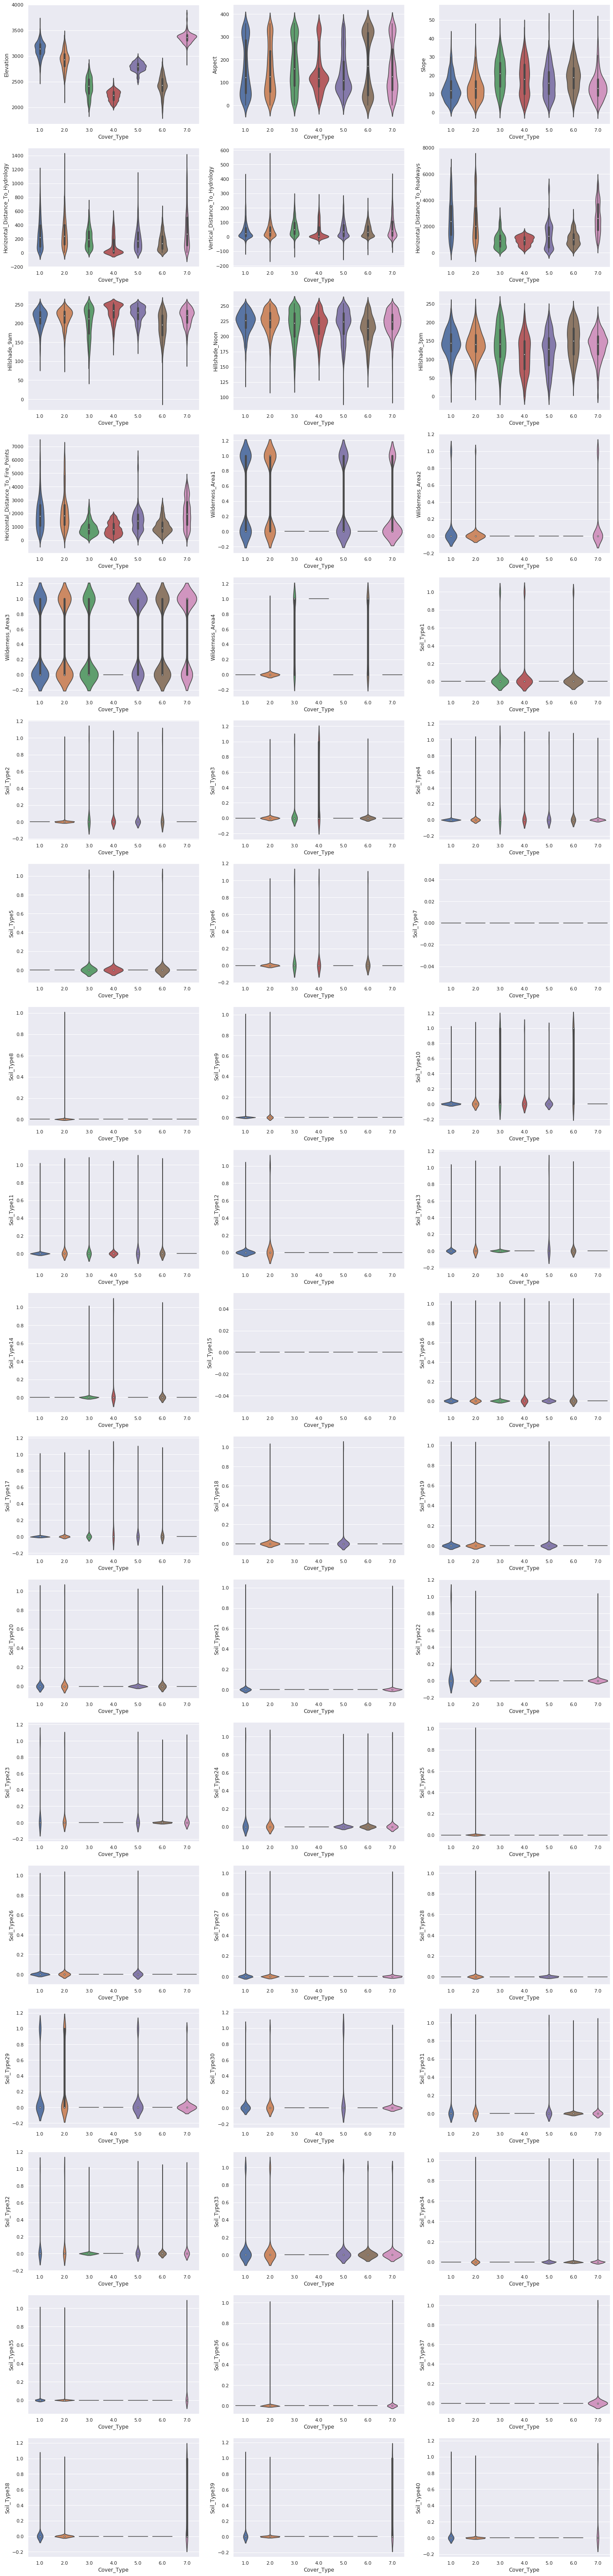

In [0]:
# Visualize the attributes using Violin Plot (box and density plots)
nplots = forest_train_df.shape[1] - 1 # without target
plt_ncols = 3
plt_nrows = int(np.ceil(nplots / plt_ncols))

plt.figure(figsize=((6 + 2)*plt_ncols,(4 + 2)*plt_nrows))
for i in tqdm_notebook(range(nplots)):
    plt.subplot(plt_nrows, plt_ncols, i + 1)
    sns.violinplot(data=forest_train_df, x='Cover_Type', y=forest_train_df.columns[i])
    # if i > 5: break

## Classification

We start with splitting the dataset into train set and test set using usual 1/3 ratio.

**Random Forest Classifier** without any tunning shows the accuracy around **85%**.

RFC performs well on the original, not transformed dataset, but for other classifiers like SVM we need to normalize the data.

After data normalization RFC performance did not change as expected, while untuned LinearSVM yields accuracy around **67%**.

### **Next step**

Now we will use feature map approximation with LinearSVM and tune its hyperparameters to get the best results.

In [0]:
print(f'Whole dataset: {forest_train_df.shape}')
n_features, m_samples = forest_train_df.shape

ids = np.arange(forest_train_df.shape[0])
ids_size = 15120  # all
# ids_size =  5000  # 1/3
# ids_size =  1000
ids = np.random.choice(ids, size=ids_size, replace=False)

train_ids, test_ids = sklearn.model_selection.train_test_split(ids)
print(f'Train ids: {train_ids.shape}')
print(f'Test  ids: {test_ids.shape}')

X = forest_train_df.iloc[:,:-1]
y = forest_train_df.iloc[:,-1]

X_train = X.iloc[train_ids]
X_test = X.iloc[test_ids]
y_train = y.iloc[train_ids]
y_test = y.iloc[test_ids]

print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Test  set: {X_test.shape}, {y_test.shape}')

Whole dataset: (15120, 55)
Train ids: (11340,)
Test  ids: (3780,)
Train set: (11340, 54), (11340,)
Test  set: (3780, 54), (3780,)


In [0]:
def test_model(m, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    score = accuracy_score(y_test, preds)
    print(score, m.__class__)

%time test_model(RandomForestClassifier())  # ~85%

0.8605820105820106 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CPU times: user 2.32 s, sys: 7 ms, total: 2.33 s
Wall time: 2.33 s


In [0]:
# Need to normalize the data so the SVM might have a chance
fst_categorical_col = 10
non_categorical_columns = np.arange(10)

max_values = forest_train_df.max(axis=0)
min_values = forest_train_df.min(axis=0)

forest_train_df_norm = (forest_train_df - min_values) / (max_values - min_values)  # normalize to [0,1]
forest_train_df_norm.iloc[:,fst_categorical_col:] = forest_train_df.iloc[:,fst_categorical_col:]  # leave categorical columns alone!

X_norm = forest_train_df_norm.iloc[:,:-1]

X_train_norm = X_norm.iloc[train_ids]
X_test_norm = X_norm.iloc[test_ids]

data_norm = dict(X_train=X_train_norm, X_test=X_test_norm)

test_model(RandomForestClassifier(), **data_norm)
# test_model(MultinomialNB(), **data_norm)  # weak
test_model(LinearSVC(), **data_norm)  # ~66%

gamma_auto = 1. / X_train.shape[1]
print(f"gamma='auto' is {gamma_auto}")

0.8621693121693121 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
0.6703703703703704 <class 'sklearn.svm._classes.LinearSVC'>
gamma='auto' is 0.018518518518518517


## Tune hyperparameters - GridSearchCV

We would like to do better than not tuned LinearSVM.

Initial tests show that our best bet is the polynomial kernel, so we tried to search for the best parameters (regularization C and polynomial degree).

Increasing the degree and the C shows that we may get better accuracy, but the number of iterations in the LinearSVM also increases.

In the Grid Search we used relatively small parameters with three times longer iteration bound than default. We reached better accuracy, but just slightly above 70%.

Testing higher values for C and degree greatly increases needed iterations to get convergence. Fitting the LinearSVM with feature mapped data takes around two minutes. That is 60 times longer than the Random Forest Classifier.

In [0]:
class Estimator:
    def __init__(self, max_iter=1000, kernel=None, C=None, gamma=None, degree=None):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.max_iter = max_iter

    def get_params(self, deep=False):
        assert not deep
        params = dict(kernel=self.kernel, C=self.C, gamma=self.gamma, degree=self.degree)
        return {k: v for k,v in params.items() if v is not None}

    def set_params(self, **params):
        self.__init__(**params)
        return self

    def fit(self, X, y):
        self.feature_mapper = Nystroem(kernel=self.kernel, degree=self.degree, gamma=self.gamma)
        phi_X = self.feature_mapper.fit_transform(X)
        print(f'Fitting with {self.get_params()} ; ', end='')
        self.m = LinearSVC(max_iter=self.max_iter, C=self.C)
        # self.m = SGDClassifier(max_iter=self.max_iter)
        self.m.fit(phi_X, y)
        print('Score', self.m.score(phi_X, y))
        return self

    def predict(self, X):
        phi_X = self.feature_mapper.transform(X)
        return self.m.predict(phi_X)

    def score(self, X, y):
        phi_X = self.feature_mapper.transform(X)
        return self.m.score(phi_X, y)

In [0]:
Cs = np.linspace(1e-1, 4, num=5)
degrees = np.arange(25, 10, step=-5)

param_grid = [{'kernel': ['poly'], 'degree': degrees, 'C': Cs}]
print(param_grid)

gridM = GridSearchCV(Estimator(max_iter=3000), param_grid, cv=2)
gridM.fit(X_norm,y)

[{'kernel': ['poly'], 'degree': array([25, 20, 15]), 'C': array([0.1  , 1.075, 2.05 , 3.025, 4.   ])}]
Fitting with {'kernel': 'poly', 'C': 0.1, 'degree': 25} ; Score 0.7080687830687831
Fitting with {'kernel': 'poly', 'C': 0.1, 'degree': 25} ; Score 0.6951058201058201
Fitting with {'kernel': 'poly', 'C': 0.1, 'degree': 20} ; Score 0.703968253968254
Fitting with {'kernel': 'poly', 'C': 0.1, 'degree': 20} ; Score 0.6862433862433862
Fitting with {'kernel': 'poly', 'C': 0.1, 'degree': 15} ; Score 0.6972222222222222
Fitting with {'kernel': 'poly', 'C': 0.1, 'degree': 15} ; Score 0.6720899470899471
Fitting with {'kernel': 'poly', 'C': 1.075, 'degree': 25} ; Score 0.7428571428571429
Fitting with {'kernel': 'poly', 'C': 1.075, 'degree': 25} ; Score 0.7199735449735449
Fitting with {'kernel': 'poly', 'C': 1.075, 'degree': 20} ; Score 0.7341269841269841
Fitting with {'kernel': 'poly', 'C': 1.075, 'degree': 20} ; Score 0.7199735449735449
Fitting with {'kernel': 'poly', 'C': 1.075, 'degree': 15} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7501322751322751
Fitting with {'kernel': 'poly', 'C': 2.05, 'degree': 25} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7257936507936508
Fitting with {'kernel': 'poly', 'C': 2.05, 'degree': 20} ; Score 0.742989417989418
Fitting with {'kernel': 'poly', 'C': 2.05, 'degree': 20} ; Score 0.7206349206349206
Fitting with {'kernel': 'poly', 'C': 2.05, 'degree': 15} ; Score 0.7251322751322752
Fitting with {'kernel': 'poly', 'C': 2.05, 'degree': 15} ; Score 0.7218253968253968
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 25} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7461640211640211
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 25} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7353174603174604
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 20} ; Score 0.7506613756613757
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 20} ; Score 0.7298941798941799
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 15} ; Score 0.7411375661375661
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 15} ; Score 0.7195767195767195
Fitting with {'kernel': 'poly', 'C': 4.0, 'degree': 25} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7472222222222222
Fitting with {'kernel': 'poly', 'C': 4.0, 'degree': 25} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7404761904761905
Fitting with {'kernel': 'poly', 'C': 4.0, 'degree': 20} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.7546296296296297
Fitting with {'kernel': 'poly', 'C': 4.0, 'degree': 20} ; 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score 0.730026455026455
Fitting with {'kernel': 'poly', 'C': 4.0, 'degree': 15} ; Score 0.739021164021164
Fitting with {'kernel': 'poly', 'C': 4.0, 'degree': 15} ; Score 0.7207671957671957
Fitting with {'kernel': 'poly', 'C': 3.025, 'degree': 20} ; Score 0.7194444444444444


GridSearchCV(cv=2, error_score=nan,
             estimator=<__main__.Estimator object at 0x7f42f8c4fb00>,
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([0.1  , 1.075, 2.05 , 3.025, 4.   ]),
                          'degree': array([25, 20, 15]), 'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print('Best score for training data:', gridM.best_score_) 
print('Best params:', gridM.best_estimator_.get_params())
%time gridM.best_estimator_.score(X_test_norm, y_test)

Best score for training data: 0.633994708994709
Best params: {'kernel': 'poly', 'C': 3.025, 'degree': 20}
CPU times: user 82 ms, sys: 132 ms, total: 214 ms
Wall time: 59 ms


0.717989417989418

In [0]:
def test_poly(degree, C, max_iter=15e3):
    m = Estimator(max_iter=max_iter, kernel='poly', C=C, degree=degree)
    %time m.fit(X_train_norm, y_train)
    print(m.score(X_test_norm, y_test),'\n')

test_poly(degree=35, C=10, max_iter=50e3)
test_poly(degree=25, C=9)

Fitting with {'kernel': 'poly', 'C': 10, 'degree': 35} ; Score 0.7338624338624339
CPU times: user 2min 50s, sys: 626 ms, total: 2min 51s
Wall time: 2min 50s
0.7238095238095238 

Fitting with {'kernel': 'poly', 'C': 9, 'degree': 25} ; Score 0.732010582010582
CPU times: user 55.9 s, sys: 625 ms, total: 56.6 s
Wall time: 55.8 s
0.7195767195767195 



In [0]:
feature_mapper = Nystroem(kernel='poly', degree=55, gamma=gamma_auto)

phi_X_train = feature_mapper.fit_transform(X_train_norm)
phi_X_test = feature_mapper.transform(X_test_norm)

m = LinearSVC(max_iter=15000, C=.5)
%time test_model(m, X_train=phi_X_train, X_test=phi_X_test)

0.7137566137566138 <class 'sklearn.svm._classes.LinearSVC'>
CPU times: user 1min 20s, sys: 298 ms, total: 1min 21s
Wall time: 1min 20s


## RBF feature map approximation accuracy

To speed up the previous hyperparameter tuning, we used kernel approximation method in conjunction with LinearSVM instead of using the regular kernelized SVM. 
Now we would like to compare the accuracy of those two methods and examine whether the approximated kernel was beneficial enough.  

The first method uses the SVC model with RBF kernel and the second one the LinearSVM trained on expanded features using the approximated kernel feature map.

### **Results**

Both models were tuned on the same hyperparameters. The results show that the approximated method reached the accuracy of **~70%** while the second model topped at **~78%**, but it took him three times longer than the approximated one.

### **Conclusion**

The accuracy of the tunned SVC with RBF kernel is much more significant than the approximated version. The longer time of training is well worth the accuracy gain, which is very close to the RandomForestClassifier which is the best model we could train on this dataset.

In [0]:
Cs = np.linspace(1e-1, 4, num=5)
gammas = np.linspace(1.0, 0.01, num=20)

param_grid = [{'kernel': ['rbf'], 'gamma': gammas, 'C': Cs}]
param_grid

[{'C': array([0.1  , 1.075, 2.05 , 3.025, 4.   ]),
  'gamma': array([1.        , 0.94789474, 0.89578947, 0.84368421, 0.79157895,
         0.73947368, 0.68736842, 0.63526316, 0.58315789, 0.53105263,
         0.47894737, 0.42684211, 0.37473684, 0.32263158, 0.27052632,
         0.21842105, 0.16631579, 0.11421053, 0.06210526, 0.01      ]),
  'kernel': ['rbf']}]

### Grid Search for RBF approximation

In [0]:
gridM = GridSearchCV(Estimator(max_iter=3000), param_grid, cv=3)
%time gridM.fit(X_train_norm,y_train)

Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 1.0} ; Score 0.6448412698412699
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 1.0} ; Score 0.6350529100529101
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 1.0} ; Score 0.6321428571428571
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.9478947368421052} ; Score 0.6302910052910053
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.9478947368421052} ; Score 0.6457671957671958
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.9478947368421052} ; Score 0.6402116402116402
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.8957894736842105} ; Score 0.6428571428571429
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.8957894736842105} ; Score 0.6472222222222223
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.8957894736842105} ; Score 0.6457671957671958
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.8436842105263158} ; Score 0.6354497354497355
Fitting with {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.8436842105263158} ; Sco

GridSearchCV(cv=3, error_score=nan,
             estimator=<__main__.Estimator object at 0x7f42f4853898>,
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([0.1  , 1.075, 2.05 , 3.025, 4.   ]),
                          'gamma': array([1.        , 0.94789474, 0.89578947, 0.84368421, 0.79157895,
       0.73947368, 0.68736842, 0.63526316, 0.58315789, 0.53105263,
       0.47894737, 0.42684211, 0.37473684, 0.32263158, 0.27052632,
       0.21842105, 0.16631579, 0.11421053, 0.06210526, 0.01      ]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print('Best score for training data:', gridM.best_score_) 
print('Best params:', gridM.best_estimator_.get_params())
%time gridM.best_estimator_.score(X_test_norm, y_test)

Best score for training data: 0.6992063492063493
Best params: {'kernel': 'rbf', 'C': 4.0, 'gamma': 0.37473684210526315}
CPU times: user 41.5 ms, sys: 41 ms, total: 82.5 ms
Wall time: 24.2 ms


0.6928571428571428

In [0]:
gridM = GridSearchCV(SVC(), param_grid, cv=3)
%time gridM.fit(X_train_norm, y_train)

CPU times: user 28min 58s, sys: 415 ms, total: 28min 59s
Wall time: 28min 59s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([0.1  , 1.075, 2.05 , 3.025, 4.   ]),
                          'gamma': array([1.        , 0.94789474, 0.89578947, 0.84368421, 0.79157895,
       0.73947368, 0.68736842, 0.63526316, 0.58315789, 0.53105263,
       0.47894737, 0.42684211, 0.37473684, 0.32263158, 0.27052632,
       0.21842105, 0.16631579, 0.11421053, 0.06210526, 0.01      ]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

In [0]:
print('Best score for training data:', gridM.best_score_) 
print('Best params:', gridM.best_estimator_.get_params())
%time gridM.best_estimator_.score(X_test_norm, y_test)

Best score for training data: 0.7681657848324516
Best params: {'C': 4.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1.0, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
CPU times: user 2.78 s, sys: 2.88 ms, total: 2.79 s
Wall time: 2.79 s


0.7796296296296297

---